In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm


In [13]:
# Définition du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare the Data

In [4]:
# Transformation : ajout de padding pour passer de 28x28 à 32x32 et conversion en tenseur
transform = transforms.Compose([
    transforms.Pad(2),      # Passe de 28x28 à 32x32
    transforms.ToTensor()
])

batch_size = 128

# Chargement des datasets FashionMNIST (train et validation)
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
val_dataset   = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.50MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 67.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



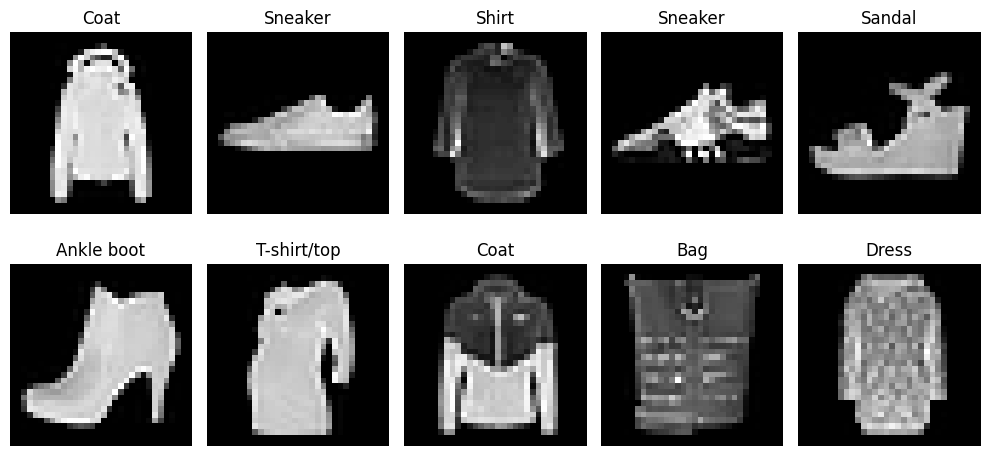

In [14]:
# Dictionnaire des labels de classes
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

def plot_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualisation d'exemple
plot_sample_images(train_loader)

#Define the VAE Model

In [22]:

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Variational Autoencoder initialization.
        Args:
            input_shape (tuple): Shape of the input image. Default is (1, 32, 32).
            latent_dim (int): Dimension of the latent representation.
        """
        super(VAE, self).__init__()

        # ------------------
        #     1. Encoder
        # ------------------
        # This block progressively reduces the spatial dimension of the input.
        # Each Conv2D layer uses stride=2 to downsample.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),  # -> 32 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),                          # -> 64 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),                         # -> 128 x 4 x 4
            nn.ReLU()
        )

        # Dynamically calculate the flattened size after all convolution layers
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # ------------------------------------------------
        #     2. Fully Connected Layers for Latent Space
        # ------------------------------------------------
        # Two separate heads for the VAE:
        #  - fc_mu: Predicts the mean of the latent distribution
        #  - fc_logvar: Predicts the log-variance of the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent mean
        )
        self.fc_logvar = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent log variance (même dimension que mu)
        )

        # ------------------
        #     3. Decoder
        # ------------------
        # Inverts the encoder process with ConvTranspose2d (a.k.a. deconvolutions).
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),
            nn.Unflatten(1, decode_shape[1:]),  # Recrée la forme (batch, channels, H, W)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Pour obtenir des valeurs entre 0 et 1
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick:
        z = mu + sigma * eps, where eps ~ N(0, I)
        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.
        Returns:
            z (Tensor): Latent variable sampled from N(mu, sigma^2).
        """
        std = torch.exp(0.5 * logvar)  # Convertit le log-variance en écart-type
        eps = torch.randn_like(std)    # Échantillonne un bruit suivant une distribution normale
        return mu + std * eps

    def calculate_flattened_size(self, model, input_shape):
        """
        Calcule la taille aplatie après passage par l'encodeur.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            return output.numel(), output.shape

    def forward(self, x):
        """
        Forward pass for the VAE:
        1) Encode input into latent distribution parameters (mu, logvar).
        2) Sample z using the reparameterization trick.
        3) Decode z back to a reconstructed image.
        Args:
            x (Tensor): Input images.
        Returns:
            recon_x (Tensor): Reconstructed images.
            mu (Tensor): Mean of latent distribution.
            logvar (Tensor): Log-variance of latent distribution.
            z (Tensor): Sampled latent variable.
        """
        # Encode input
        x_encoded = self.encoder(x)

        # Compute mu and logvar
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode latent vector to reconstruct the input
        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z

# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = VAE()  # Remplacez "Autoencoder()" par "VAE()"
image_test, mu, logvar, z = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"


## VAE Loss Function and Training

In [23]:
def vae_loss(recon_x, x, mu, logvar, beta=1):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
    return recon_loss + beta * kl_div

def train_model(model, train_loader, val_loader, epochs, beta=1):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

        for x, _ in tqdm_loader:
            optimizer.zero_grad()
            x = x.to(device)
            recon_x, mu, logvar, _ = model(x)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tqdm_loader.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_val_loss, _ = evaluate_model(model, val_loader, beta=beta)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    plot_training_loss(train_losses, val_losses)

def evaluate_model(model, loader, beta=1):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)
            recon_x, mu, logvar, _ = model(x)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)
            total_loss += loss.item()
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, 0

def plot_training_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Reconstruct Images

In [24]:
def plot_reconstructions(model, loader_or_z, ex=True, num_samples=5):
    model.eval()
    model = model.to("cpu")

    with torch.no_grad():
        if ex:
            for x, _ in loader_or_z:
                recon_x, _, _, _ = model(x)
                break
        else:
            x = None
            recon_x = model.decoder(loader_or_z)

    if x is not None:
        x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if x is not None:
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconst.")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Visualize the Latent Space

Entraînement du modèle VAE...


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch [1/10], Train Loss: 403.6781, Val Loss: 315.8824


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s]


Epoch [2/10], Train Loss: 303.3116, Val Loss: 297.0188


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 42.34it/s]


Epoch [3/10], Train Loss: 291.8112, Val Loss: 289.4405


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 50.71it/s]


Epoch [4/10], Train Loss: 286.0259, Val Loss: 285.1330


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.56it/s]


Epoch [5/10], Train Loss: 282.3203, Val Loss: 282.1397


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 44.64it/s]


Epoch [6/10], Train Loss: 279.5707, Val Loss: 279.6887


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.98it/s]


Epoch [7/10], Train Loss: 277.3470, Val Loss: 277.7028


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 50.76it/s]


Epoch [8/10], Train Loss: 275.6419, Val Loss: 276.2912


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.03it/s]


Epoch [9/10], Train Loss: 274.2420, Val Loss: 274.8842


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 53.35it/s]


Epoch [10/10], Train Loss: 273.2424, Val Loss: 274.0739


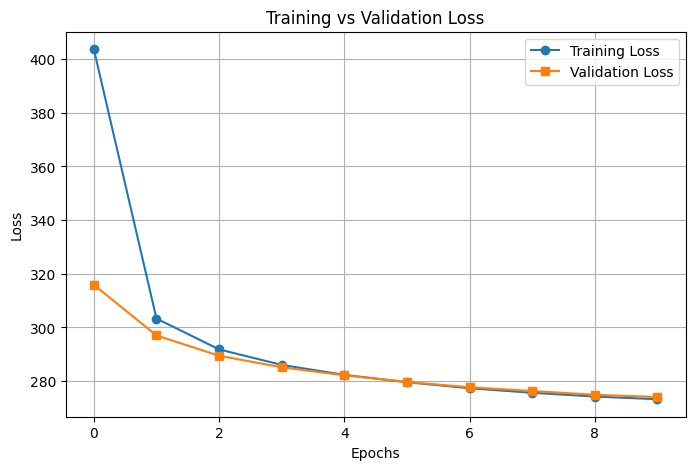

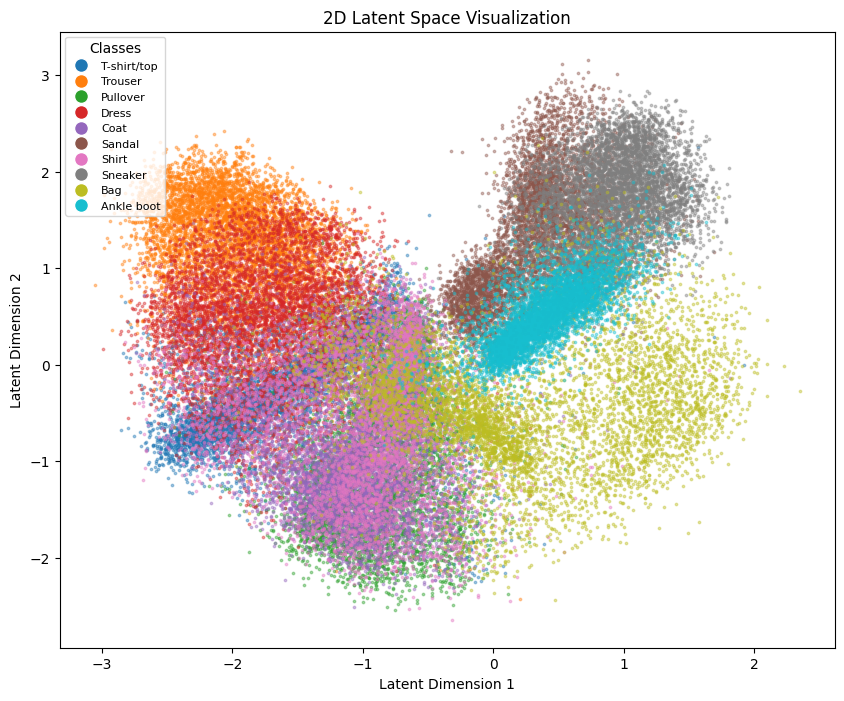

In [25]:
embeddings = []
labels = []

model = VAE().to(device)
# Pour cet exemple, nous allons entraîner le modèle à partir de zéro.
print("Entraînement du modèle VAE...")
train_model(model, train_loader, val_loader, epochs=10, beta=1.5)

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        _, _, _, latent = model(x)
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
unique_labels = np.unique(labels)
model = model.to("cpu")

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], c=[colors[i]], alpha=0.4, s=3, label=class_labels[label])
    legend_handles.append(Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}', markersize=10, markerfacecolor=colors[i]))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()


## Generate New Images

Vecteurs latents échantillonnés :
 tensor([[ 1.8602, -0.2211],
        [-0.5771,  1.5162],
        [-0.5271,  0.4630],
        [ 0.8085,  1.8110],
        [ 0.1744, -0.8016]])


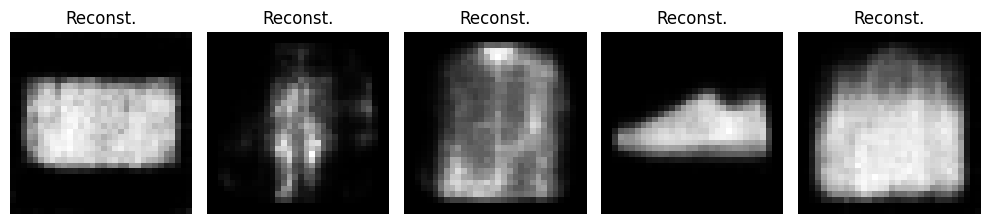

In [26]:
z_sample = torch.tensor(np.random.normal(size=(5, 2)), dtype=torch.float32)
print("Vecteurs latents échantillonnés :\n", z_sample)
plot_reconstructions(model, z_sample, ex=False)
